# Коллаборативная фильтрация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Для работы с матрицами
from scipy.sparse import csr_matrix

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns

%matplotlib inline

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from metrics import precision_at_k, recall_at_k

In [2]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [3]:
def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [4]:
def prefilter_items(data):
    # Уберем самые популярные товары (их и так купят)
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    
    # Уберем не интересные для рекоммендаций категории (department)
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    
    # Уберем слишком дорогие товары
    
    # ...
    
def postfilter_items(user_id, recommednations):
    pass

In [5]:
data = pd.read_csv('../data/transaction_data.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [6]:
item_features = pd.read_csv('../data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [7]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [8]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65..."
1,3,"[823704, 834117, 840244, 913785, 917816, 93870..."


In [9]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [10]:
data_train.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [11]:
# Заведем фиктивный item_id
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999_999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix)

user_item_matrix.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15926885,15926886,15926887,15926927,15927033,15927403,15927661,15927850,16809471,17105257
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

# ALS

In [13]:
%%time

model = AlternatingLeastSquares(factors=64, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=10,
                                random_state=42)

model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
          show_progress=True)


Wall time: 2.93 s


In [14]:
recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=sparse_user_item.tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

In [15]:
recs

[(3679, 1.0002503008838695),
 (4011, 0.9945741308114094),
 (2371, 0.9823673519739442),
 (3397, 0.9384953654481303),
 (4150, 0.9255877313887794)]

In [16]:
[id_to_itemid[rec[0]] for rec in recs]

[1106523, 1133018, 999999, 1082185, 5569230]

In [17]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

Wall time: 17.6 s


0.1552988448016051

In [18]:
result.head(2)

,user_id,actual,als
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[1033142, 1100972, 5569374, 979707, 901062]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[1106523, 908531, 5568378, 5569327, 951590]"


### Embeddings

In [19]:
model.item_factors.shape

(5001, 64)

In [20]:
model.user_factors.shape

(2500, 64)

In [21]:
#model.rank_items()

Можно очень быстро посчитать предсказания, перемножив эти 2 матрицы

In [22]:
fast_recs = model.user_factors @ model.item_factors.T 
fast_recs.shape

(2500, 5001)

In [23]:
fast_recs[0,:]

array([-0.01015962, -0.00407727, -0.02151076, ..., -0.01224831,
       -0.13940428, -0.07573149], dtype=float32)

In [24]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=sparse_user_item.tocsr(),
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)
recommendations


Wall time: 16.9 s


array([[3605,  191, 3019,  822, 2685],
       [2297, 2747, 2134, 4337, 1170],
       [2747,  557, 3377, 1908, 2297],
       ...,
       [4337, 2297, 3575, 2134,  557],
       [2747, 2838, 2297,  655,  298],
       [3679,  557, 4054,   76, 2447]], dtype=int32)

In [25]:
recommendations.shape

(2500, 5)

# Оценка качества

In [26]:
model.item_factors.shape

(5001, 64)

In [27]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [28]:
print(category[:10])

['MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'MISC SALES TRAN', 'KIOSK-GAS', 'GROCERY', 'GROCERY', 'GROCERY']


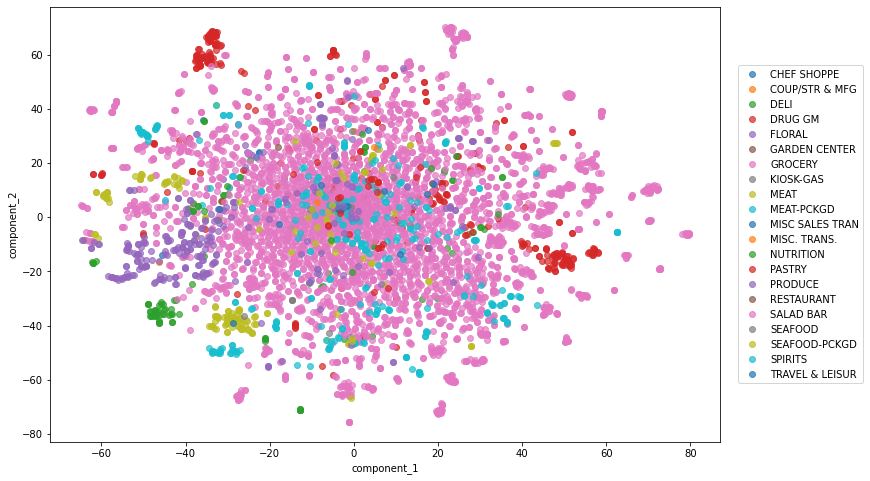

Wall time: 33.7 s


In [29]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Нарисуем все, кроме GROCERY

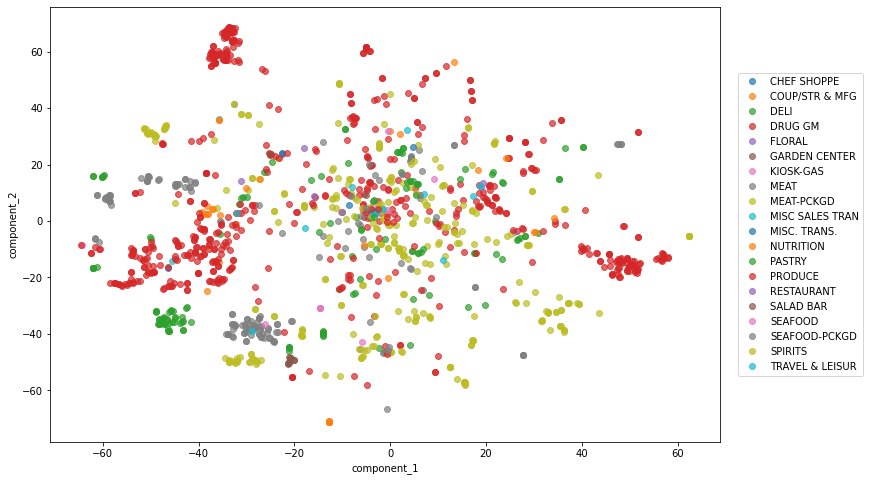

In [30]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

Нарисуем несколько конкретных категорий

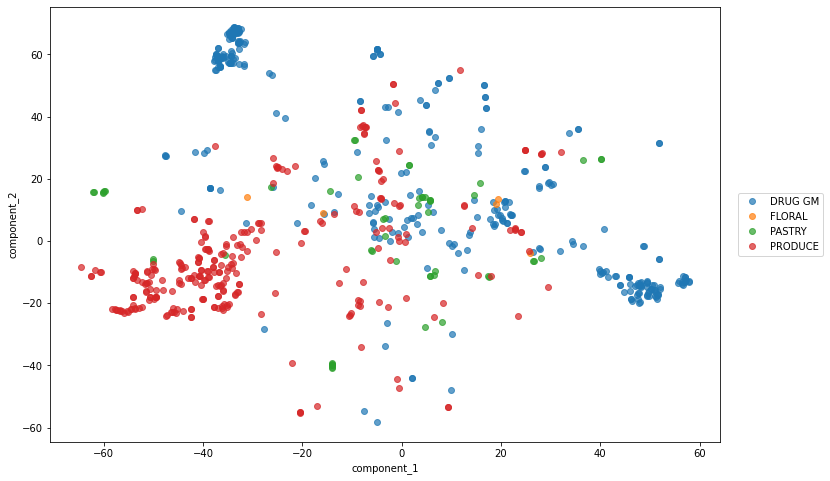

In [31]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

На самом деле, я бы сказал, что **результат средний**:
- Модель выучила похожесть только небольшой части товаров

In [32]:
item_emb_tsne.head(2)

,component_1,component_2,category
0,-3.657057,3.452805,MISC SALES TRAN
1,-1.457783,4.318961,KIOSK-GAS


recommend_all делает перемножение, но еще и сортирует и выбирает топ-N

In [33]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

In [34]:
item_1.shape

(64,)

*Посмотрите также / Похожие товары*

In [35]:
example_item_row_id = 3606

In [36]:
id_to_itemid[example_item_row_id]

1101010

In [37]:
closest_items = [ id_to_itemid[row_id] for row_id, score in model.similar_items(example_item_row_id, N=5)]

In [38]:
item_features[item_features.item_id.isin(closest_items)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
5915,819978,3544,DELI,National,CHEESES,CHEESE: PROCESSED BULK,
28449,1018740,3516,DELI,National,DELI MEATS,MEAT:HAM BULK,
30927,1040807,3544,DELI,National,CHEESES,CHEESE: PROCESSED BULK,
31252,1043751,4376,DELI,National,DELI MEATS,MEAT:HAM BULK,
37665,1101010,3862,DELI,National,DELI MEATS,MEAT: LUNCHMEAT BULK,


*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [39]:
model.similar_users(userid_to_id[10], N=5)

[(9, 1.0),
 (790, 0.984045),
 (354, 0.9792586),
 (2149, 0.9778068),
 (1681, 0.97773826)]

### 2. TF-IDF взвешивание

In [40]:
user_item_matrix_tf_idf = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [41]:
%%time
for factor in (32,64,128):
    model = AlternatingLeastSquares(factors=factor, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=10,
                                random_state=42)
    model.fit(csr_matrix(user_item_matrix_tf_idf).T.tocsr(),  # На вход item-user matrix
          show_progress=True)
    result['als_tf_idf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    print(result.apply(lambda row: precision_at_k(row['als_tf_idf'], row['actual']), axis=1).mean())


0.1686589653440457



0.162832747363132



0.14967353088899857
Wall time: 1min 12s


### 3. BM25 взвешивание

In [42]:
user_item_matrix_bm25 = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [43]:
%%time
for factor in (32,64,128):
    model = AlternatingLeastSquares(factors=factor, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=10,
                                random_state=42)
    model.fit(csr_matrix(user_item_matrix_bm25).T.tocsr(),  # На вход item-user matrix
          show_progress=True)
    result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    print(result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean())


0.16142641888498016



0.17348066298342302



0.1920642893018553
Wall time: 1min 12s


Сравнивая значения метрики __precision_at_k__ при __TF-IDF__ взвешивании и __BM25__ взвешивании, приходим к выводу, что при одинаковых значениях параметра __factors__ - __BM25__ взвешивание лучше работает.

In [44]:
%%time
for factor in range(120, 129):
    model = AlternatingLeastSquares(factors=factor, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=10,
                                random_state=42)
    model.fit(csr_matrix(user_item_matrix_bm25).T.tocsr(),  # На вход item-user matrix
          show_progress=True)
    result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    print(f'factor = {factor} ')
    print(result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean())


factor = 120 
0.18663987945755608



factor = 121 
0.1901557006529355



factor = 122 
0.1890507282772448



factor = 123 
0.19186338523354815



factor = 124 
0.1876443997990931



factor = 125 
0.19316926167754636



factor = 126 
0.18834756403816896



factor = 127 
0.18734304369663174



factor = 128 
0.1920642893018553
Wall time: 5min 47s


In [45]:
%%time
for iteration in range(12,18):
    for reg in np.arange(0.03, 0.1, 0.01):
        model = AlternatingLeastSquares(factors=125, 
                                regularization=reg,
                                iterations=iteration, 
                                calculate_training_loss=True, 
                                num_threads=10,
                                random_state=42)
        model.fit(csr_matrix(user_item_matrix_bm25).T.tocsr(),  # На вход item-user matrix
              show_progress=True)
        result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        print(f'iterations = {iteration}, regularization = {reg} :')
        print(result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean())


iterations = 12, regularization = 0.03 :
0.19477649422400534



iterations = 12, regularization = 0.04 :
0.19427423405323696



iterations = 12, regularization = 0.05 :
0.19326971371170004



iterations = 12, regularization = 0.060000000000000005 :
0.19347061778000732



iterations = 12, regularization = 0.07 :
0.1939728779507758



iterations = 12, regularization = 0.08000000000000002 :
0.19397287795077586



iterations = 12, regularization = 0.09000000000000001 :
0.19377197388246847



iterations = 12, regularization = 0.1 :
0.19427423405323688



iterations = 13, regularization = 0.03 :
0.19437468608739067



iterations = 13, regularization = 0.04 :
0.194575590155698



iterations = 13, regularization = 0.05 :
0.19427423405323702



iterations = 13, regularization = 0.060000000000000005 :
0.19387242591662215



iterations = 13, regularization = 0.07 :
0.1926670015067779



iterations = 13, regularization = 0.08000000000000002 :
0.19306880964339265



iterations = 13, regularization = 0.09000000000000001 :
0.19226519337016315



iterations = 13, regularization = 0.1 :
0.19226519337016304



iterations = 14, regularization = 0.03 :
0.19427423405323696



iterations = 14, regularization = 0.04 :
0.194274234053237



iterations = 14, regularization = 0.05 :
0.19347061778000743



iterations = 14, regularization = 0.060000000000000005 :
0.19397287795077583



iterations = 14, regularization = 0.07 :
0.1929683576092389



iterations = 14, regularization = 0.08000000000000002 :
0.19276745354093155



iterations = 14, regularization = 0.09000000000000001 :
0.19236564540431675



iterations = 14, regularization = 0.1 :
0.19276745354093142



iterations = 15, regularization = 0.03 :
0.1941737820190832



iterations = 15, regularization = 0.04 :
0.1940733299849296



iterations = 15, regularization = 0.05 :
0.19316926167754636



iterations = 15, regularization = 0.060000000000000005 :
0.19326971371170004



iterations = 15, regularization = 0.07 :
0.19397287795077583



iterations = 15, regularization = 0.08000000000000002 :
0.19266700150677782



iterations = 15, regularization = 0.09000000000000001 :
0.19226519337016296



iterations = 15, regularization = 0.1 :
0.19276745354093142



iterations = 16, regularization = 0.03 :
0.19517830236062006



iterations = 16, regularization = 0.04 :
0.19417378201908322



iterations = 16, regularization = 0.05 :
0.19367152184831482



iterations = 16, regularization = 0.060000000000000005 :
0.19347061778000743



iterations = 16, regularization = 0.07 :
0.19276745354093158



iterations = 16, regularization = 0.08000000000000002 :
0.19216474133600941



iterations = 16, regularization = 0.09000000000000001 :
0.1918633852335483



iterations = 16, regularization = 0.1 :
0.19186338523354826



iterations = 17, regularization = 0.03 :
0.19357106981416095



iterations = 17, regularization = 0.04 :
0.1934706177800073



iterations = 17, regularization = 0.05 :
0.1930688096433926



iterations = 17, regularization = 0.060000000000000005 :
0.1933701657458537



iterations = 17, regularization = 0.07 :
0.1928679055750852



iterations = 17, regularization = 0.08000000000000002 :
0.19266700150677787



iterations = 17, regularization = 0.09000000000000001 :
0.19316926167754628



iterations = 17, regularization = 0.1 :
0.1930688096433926
Wall time: 30min 43s


#### Запустим модель с наилучшими найденными параметрами и сохраним в файл "predictions_mf.csv"

In [48]:
model = AlternatingLeastSquares(factors=125, 
                                regularization=0.03,
                                iterations=16, 
                                calculate_training_loss=True, 
                                num_threads=10,
                                random_state=42)
model.fit(csr_matrix(user_item_matrix_bm25).T.tocsr(),  # На вход item-user matrix
          show_progress=True)
result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
print(result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean())


0.19517830236062006


In [49]:
result.to_csv('../predictions_mf.csv', index=False)  # mf - matrix factorization